In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [4]:
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" -d '/content/gdrive/MyDrive/'


Archive:  /content/gdrive/MyDrive/CNN_assignment.zip
replace /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/gdrive/MyDrive/Skin cancer ISIC The Internati

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### **Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### **Create a dataset**

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split=0.2,
    image_size = (img_height,img_width),
    batch_size = batch_size,
    subset = "training"
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split = 0.2,
    image_size = (img_height,img_width),
    batch_size = batch_size,
    subset = "validation"
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:
#Let's take first 32 elements from train_ds
train_ds.take(32)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
#Also let's check out the shape
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### **Visualize the data**

create a code to visualize one instance of all the nine classes present in the dataset

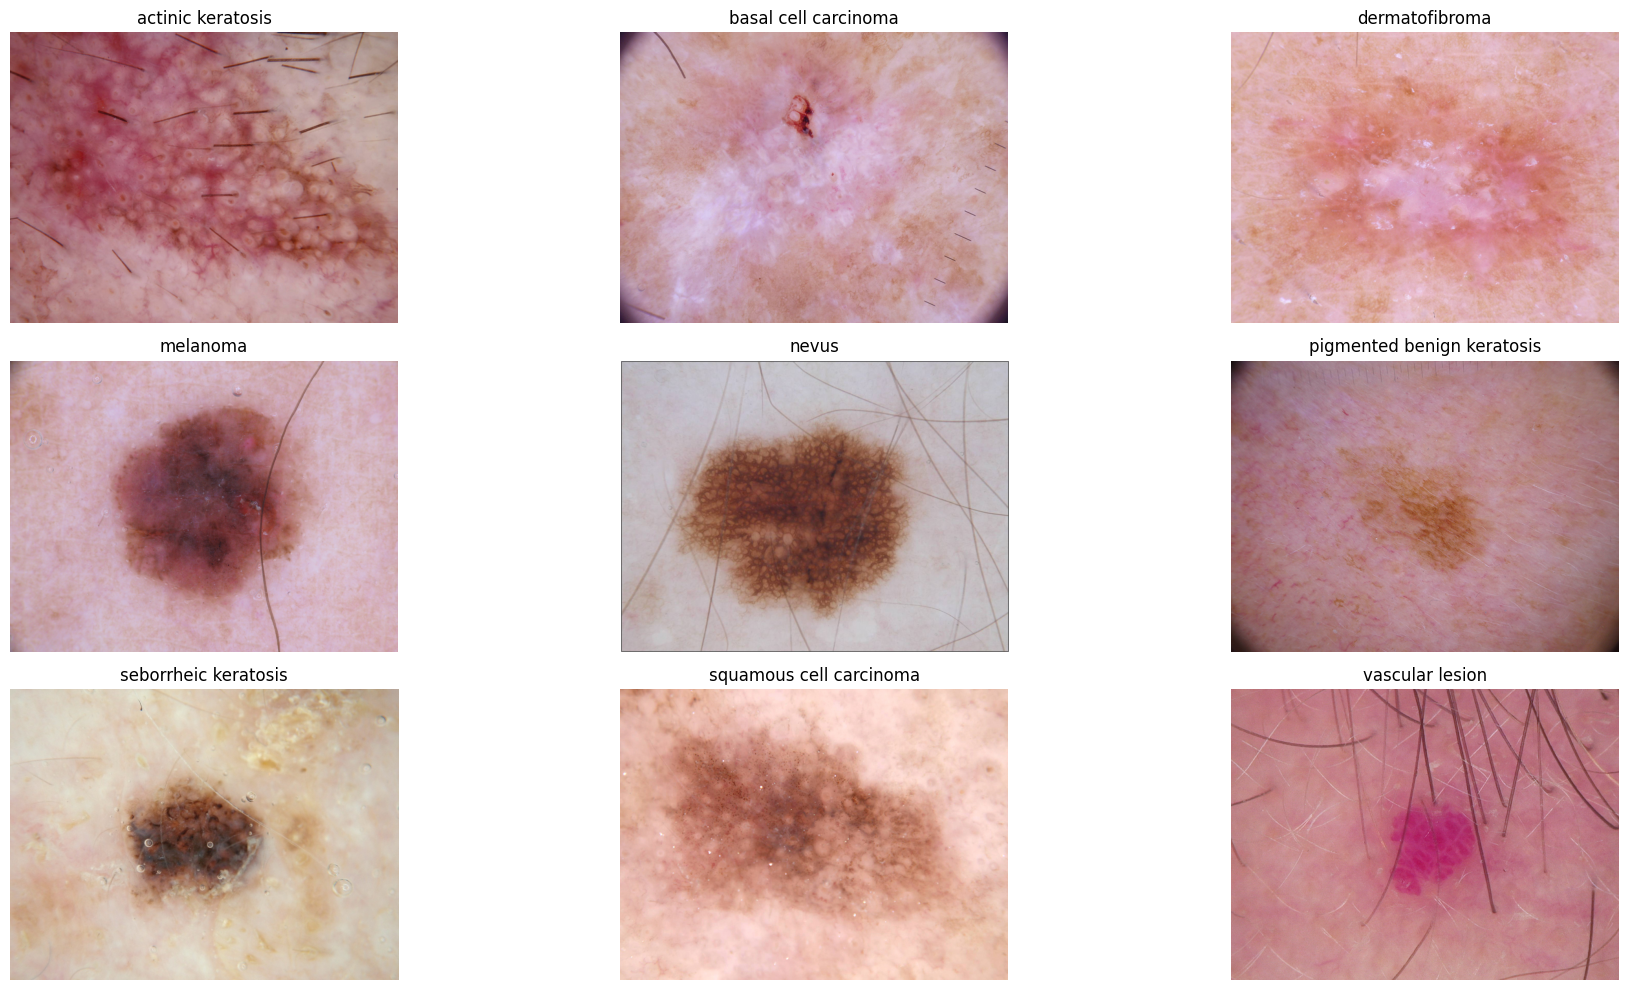

In [13]:
plt.figure(figsize=(20, 10))

for i in range(len(class_names)):
    class_name = class_names[i]
    image_path = list(data_dir_train.glob(f'{class_name}/*.jpg'))[0]
    image = plt.imread(str(image_path))
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

### **Visualize distribution of classes in the training dataset**

In [14]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

Class  No. of Image
0           actinic keratosis           114
1        basal cell carcinoma           376
2              dermatofibroma            95
3                    melanoma           438
4                       nevus           357
5  pigmented benign keratosis           462
6        seborrheic keratosis            77
7     squamous cell carcinoma           181
8             vascular lesion           139

<Axes: xlabel='No. of Image', ylabel='Class'>

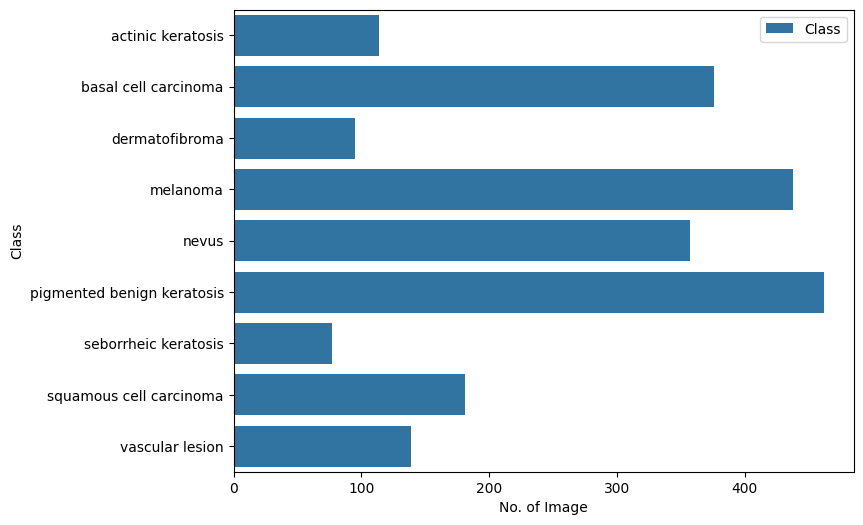

In [15]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB).

The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Create the model**
Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use `layers.experimental.preprocessing.Rescaling` to normalize pixel values between `(0,1)`.

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network.

Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
classes_nums = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential()

model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

#First Convolution layer
model.add(layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
#Pooling Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Second Convolution Layer
model.add(layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
#Adding another Pooling layer
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Third Convulation Layer
#Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
model.add(layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(2,2)))


#Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
##Flattens the input. Does not affect the batch size.

model.add(layers.Flatten())

#fully connected layer (Dense layer)
model.add(layers.Dense(128, activation="relu"))

# Output neuron
model.add(layers.Dense(classes_nums, activation='softmax'))

### **Compile the model**
Choose an appropirate optimiser and loss function for model training

In [18]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

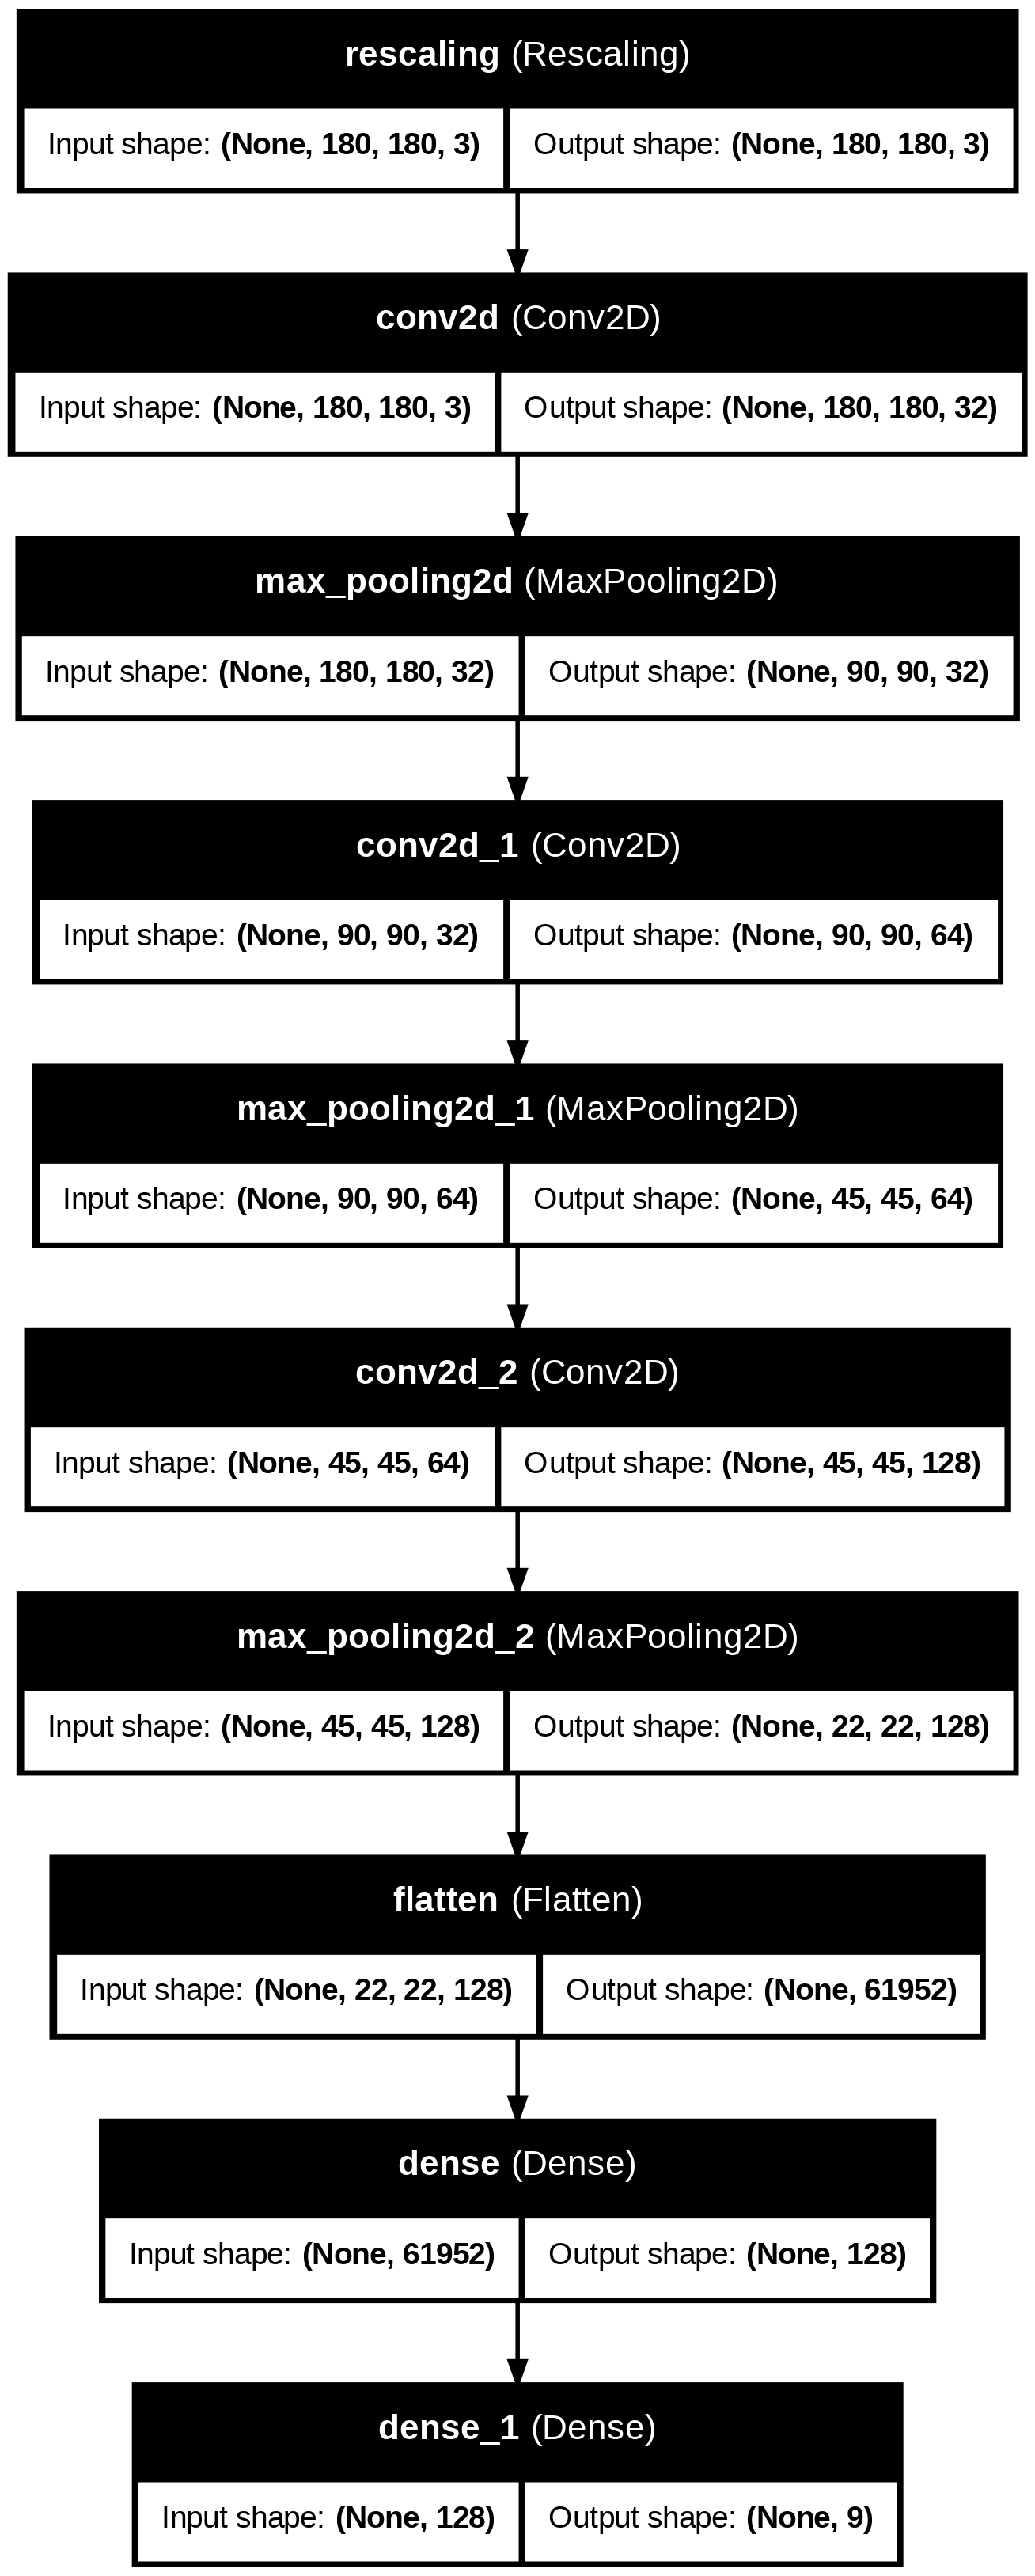

In [20]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### **Train the model**

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 817s 1s/step - accuracy: 0.1879 - loss: 2.2673 - val_accuracy: 0.4120 - val_loss: 1.5477
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4520 - loss: 1.4524 - val_accuracy: 0.5048 - val_loss: 1.3085
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5479 - loss: 1.1951 - val_accuracy: 0.6006 - val_loss: 1.1124
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6140 - loss: 1.0372 - val_accuracy: 0.6088 - val_loss: 1.0673
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6786 - loss: 0.9027 - val_accuracy: 0.6719 - val_loss: 0.9516
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6983 - loss: 0.8069 - val_accuracy: 0.6964 - val_loss: 0.8550
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7727 - loss: 0.6364 - val_accuracy: 0.7372 - val_loss: 0.7799
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8161 - loss: 0.5007 - val_

### **Visualizing training results**

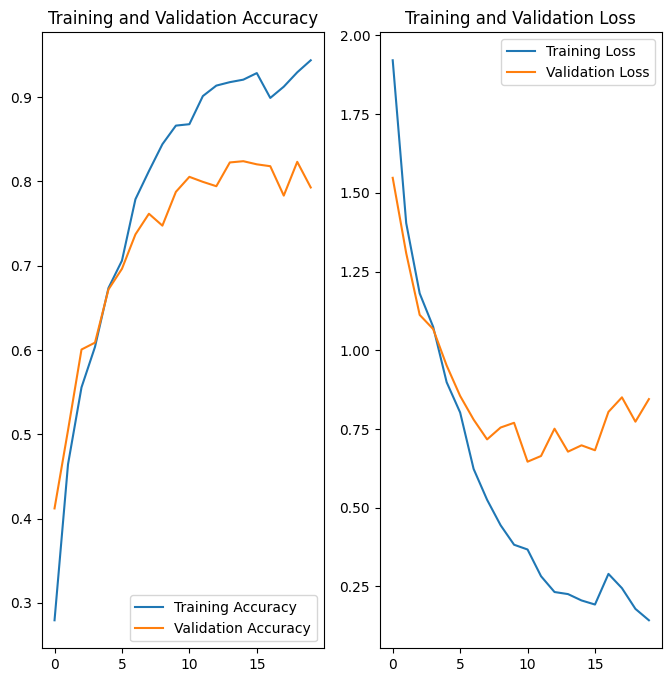

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Inference:** As we can see, the model is clearly overfitting, with less than 85% as training accuracies and less than 55% as validation accuracies.

Model is good on Training Accuracy but not on Validation.

### Write your findings here

In [23]:

# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",      # We do the horizontal flip method to augment
    input_shape=(img_height,
                img_width,
                3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.RandomCrop(img_height,img_width),
  ]
)


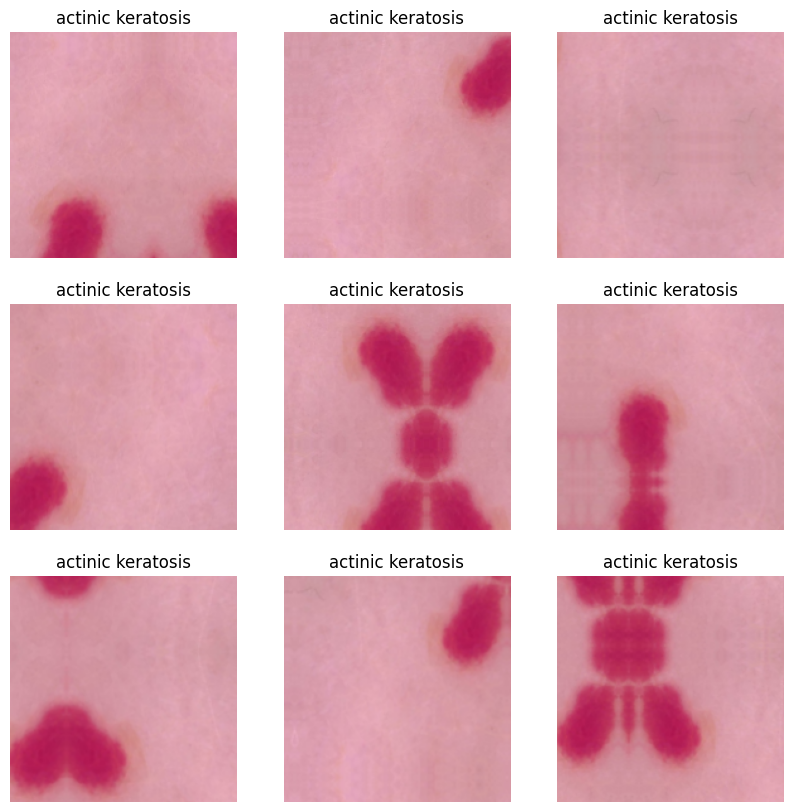

In [24]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[0])

### Todo:
### Create the model, compile and train the model

In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
classes_nums = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential()

# Add input layer explicitly to ensure the input shape is passed
model.add(layers.InputLayer(input_shape=(img_height, img_width, 3)))

# Add Augmented data
model.add(data_augmentation)

model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

#First Convolution layer
model.add(layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
#Pooling Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Second Convolution Layer
model.add(layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
#Adding another Pooling layer
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Third Convolation Layer
#Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
model.add(layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(2,2)))

# Let us add some dropouts
model.add(layers.Dropout(0.25)),

#Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
##Flattens the input. Does not affect the batch size.

model.add(layers.Flatten())

#fully connected layer (Dense layer)
model.add(layers.Dense(128, activation="relu"))

# Output neuron
model.add(layers.Dense(classes_nums, activation='softmax'))

### Compiling the model

In [26]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [27]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 123904)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      15,859,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,231,817 (61.92 MB)

 Trainable params: 16,231,817 (61.92 MB)

 Non-trainable params: 0 (0.00 B)

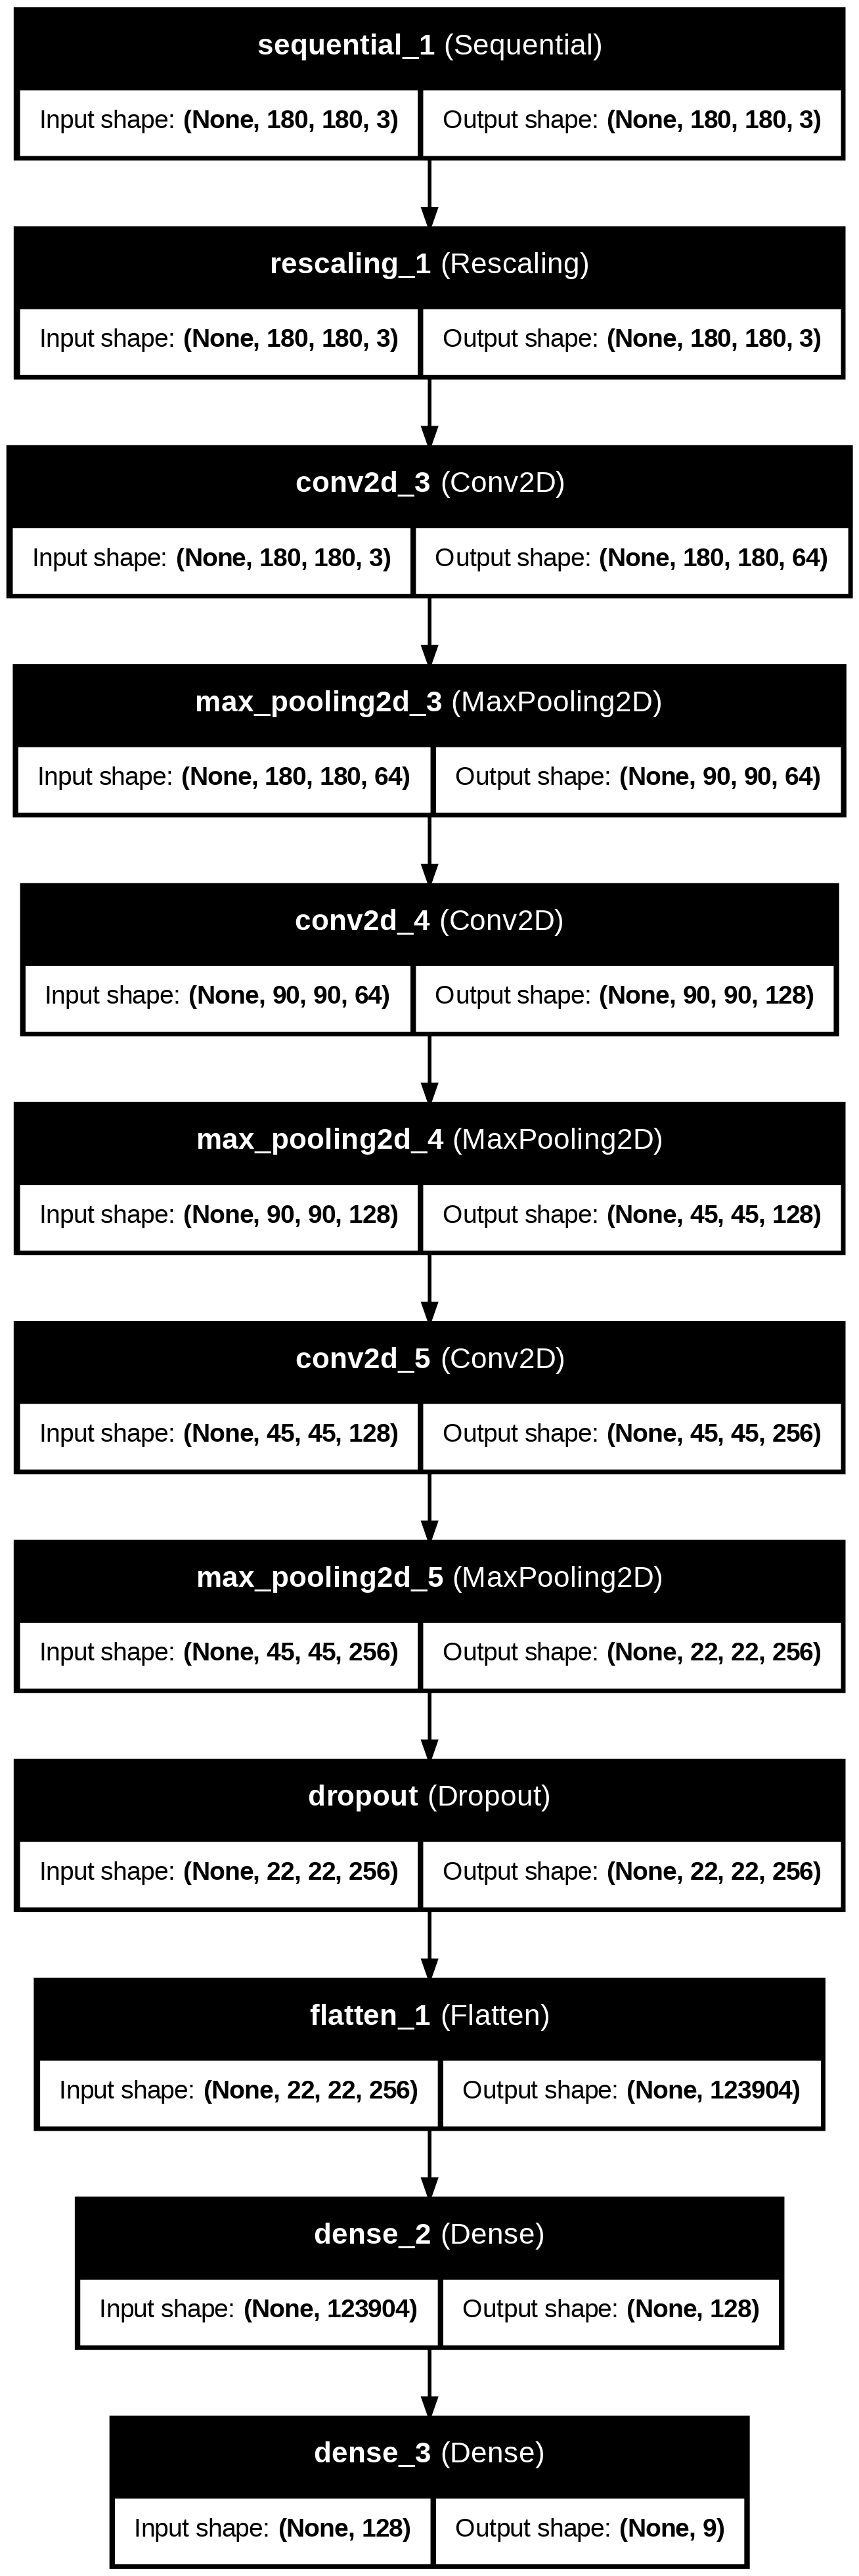

In [28]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Training the model

In [29]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - accuracy: 0.1763 - loss: 2.3467 - val_accuracy: 0.2702 - val_loss: 1.8024
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.2774 - loss: 1.7888 - val_accuracy: 0.3103 - val_loss: 1.7235
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.3136 - loss: 1.7405 - val_accuracy: 0.3467 - val_loss: 1.6561
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.3457 - loss: 1.6410 - val_accuracy: 0.3571 - val_loss: 1.6870
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.3743 - loss: 1.6420 - val_accuracy: 0.3979 - val_loss: 1.5354
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.3828 - loss: 1.5781 - val_accuracy: 0.4083 - val_loss: 1.5512
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.4008 - loss: 1.4987 - val_accuracy: 0.4031 - val_loss: 1.4760
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.4093 - loss: 1

### Visualizing the results

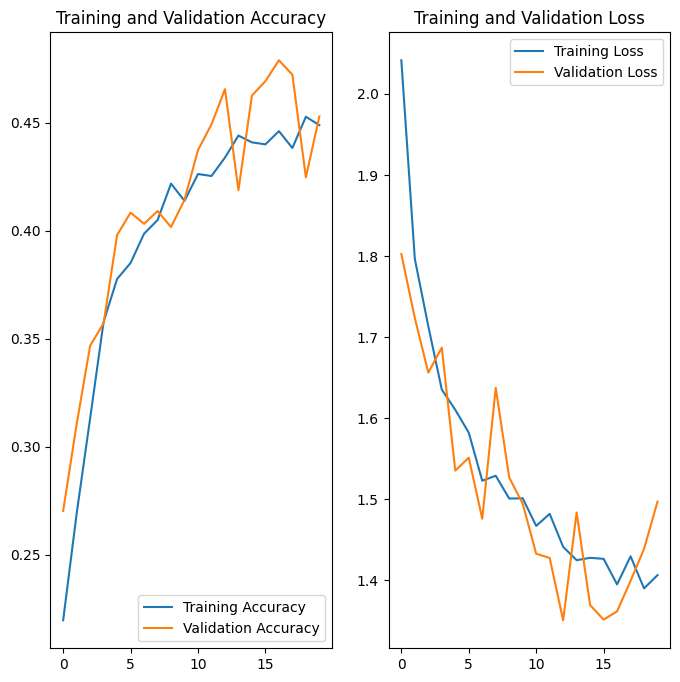

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Inference: From the above we can infer that, the validation accuracy is catching up with training accuracy. But the overall accuracy is very less for both train and validation. This is a clear case of underfitting with 50% and 50% train and validation accuaracies respectively

**Todo:** Find the distribution of classes in the training dataset.

**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [31]:
path_list=[]
label_list=[]
for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        label_list.append(i)
dataframe_dict_original = dict(zip(path_list, label_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df


Path              Label
0     /content/gdrive/MyDrive/Skin cancer ISIC The I...  actinic keratosis
1     /content/gdrive/MyDrive/Skin cancer ISIC The I...  actinic keratosis
2     /content/gdrive/MyDrive/Skin cancer ISIC The I...  actinic keratosis
3     /content/gdrive/MyDrive/Skin cancer ISIC The I...  actinic keratosis
4     /content/gdrive/MyDrive/Skin cancer ISIC The I...  actinic keratosis
...                                                 ...                ...
2234  /content/gdrive/MyDrive/Skin cancer ISIC The I...    vascular lesion
2235  /content/gdrive/MyDrive/Skin cancer ISIC The I...    vascular lesion
2236  /content/gdrive/MyDrive/Skin cancer ISIC The I...    vascular lesion
2237  /content/gdrive/MyDrive/Skin cancer ISIC The I...    vascular lesion
2238  /content/gdrive/MyDrive/Skin cancer ISIC The I...    vascular lesion

[2239 rows x 2 columns]

Class=actinic keratosis, Class_label=0, n=114 (5.092%)
Class=basal cell carcinoma, Class_label=1, n=376 (16.793%)
Class=dermatofibroma, Class_label=2, n=95 (4.243%)
Class=melanoma, Class_label=3, n=438 (19.562%)
Class=nevus, Class_label=4, n=357 (15.945%)
Class=pigmented benign keratosis, Class_label=5, n=462 (20.634%)
Class=seborrheic keratosis, Class_label=6, n=77 (3.439%)
Class=squamous cell carcinoma, Class_label=7, n=181 (8.084%)
Class=vascular lesion, Class_label=8, n=139 (6.208%)


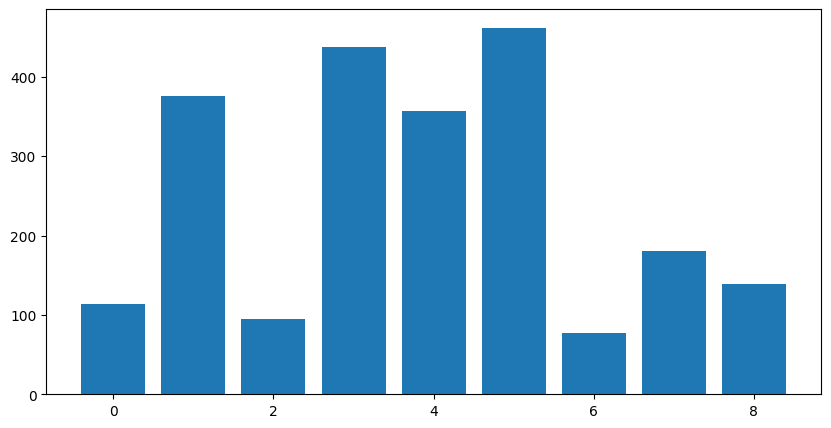

In [32]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# split into input and output elements
plt.figure(figsize=(10,5))
X, y = original_df['Path'], original_df['Label']

# label encode the target variable
y = LabelEncoder().fit_transform(y)


# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	  percent = v / len(y) * 100
	  print('Class=%s, Class_label=%d, n=%d (%.3f%%)' % (class_names[k], k, v, percent))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

Todo: Write your findings here:
1. Which class has the least number of samples?

- Seborrheic keratosis has the least number of samples

2. Which classes dominate the data in terms proportionate number of samples?

- Pigmented benign keratosis has the domination on the model as in terms of number of samples

**Todo:** Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [33]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:


1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.

2. Define a number of operations to perform on this data set using your Pipeline object.

3. Execute these operations by calling the Pipeline’s sample() method.





In [34]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EE646F6DDE0>: 100%|██████████| 500/500 [00:18<00:00, 26.60 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE646E6E4D0>: 100%|██████████| 500/500 [00:20<00:00, 24.38 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE6B0A89120>: 100%|██████████| 500/500 [00:19<00:00, 26.30 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7EE646FE7580>: 100%|██████████| 500/500 [01:25<00:00,  5.87 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1011x713 at 0x7EE64661B5E0>: 100%|██████████| 500/500 [01:23<00:00,  6.00 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE647E44610>: 100%|██████████| 500/500 [00:18<00:00, 26.85 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EE646EBEF20>: 100%|██████████| 500/500 [00:40<00:00, 12.39 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE647E446A0>: 100%|██████████| 500/500 [00:18<00:00, 27.10 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE6B052C700>: 100%|██████████| 500/500 [00:19<00:00, 25.35 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [35]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029460.jpg_3cbdbea6-7fa8-411c-81fc-4d5afd45dc4f.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029713.jpg_ded5ed6f-1317-46b2-8d1c-4f7bef5352a6.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030730.jpg_2bdd92a0-c704-4ed9-84bf-9d05c5652ac1.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_461004ca-5c91-47d1-b361-fb98e213a5ad.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027884.jpg_01690947-9496

In [37]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [38]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [40]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

**Todo:** Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

**Todo:** Create a training dataset

In [42]:
data_dir_train="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


**Todo:** Create a validation dataset


In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


### **Autotuning**

In [44]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Todo:** Create your model (make sure to include normalization)


In [45]:
## your code goes here

classes_nums = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential()

model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

#First Convolution layer
model.add(layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
#Pooling Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Second Convolution Layer
model.add(layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
#Adding another Pooling layer
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Third Convulation Layer
#Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
model.add(layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(2,2)))

# Let us add some dropouts
model.add(layers.Dropout(0.25)),

#Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
##Flattens the input. Does not affect the batch size.
model.add(layers.Flatten())

#fully connected layer (Dense layer)
model.add(layers.Dense(128, activation="relu"))

# Output neuron
model.add(layers.Dense(classes_nums, activation='softmax'))

**Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [46]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Todo:** Train your model

In [47]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 80s 96ms/step - accuracy: 0.2407 - loss: 2.1175 - val_accuracy: 0.4085 - val_loss: 1.5550
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.4963 - loss: 1.3429 - val_accuracy: 0.5225 - val_loss: 1.2742
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.5955 - loss: 1.1011 - val_accuracy: 0.6342 - val_loss: 1.0273
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.6649 - loss: 0.9184 - val_accuracy: 0.6836 - val_loss: 0.9159
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7420 - loss: 0.6893 - val_accuracy: 0.7548 - val_loss: 0.6855
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8066 - loss: 0.5360 - val_accuracy: 0.7859 - val_loss: 0.6421
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.8406 - loss: 0.4278 - val_accuracy: 0.8220 - val_loss: 0.5362
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.8736 - loss: 0.3345 - val_a

In [48]:
# View the summary of all layers
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,073,181 (91.83 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,048,788 (61.22 MB)

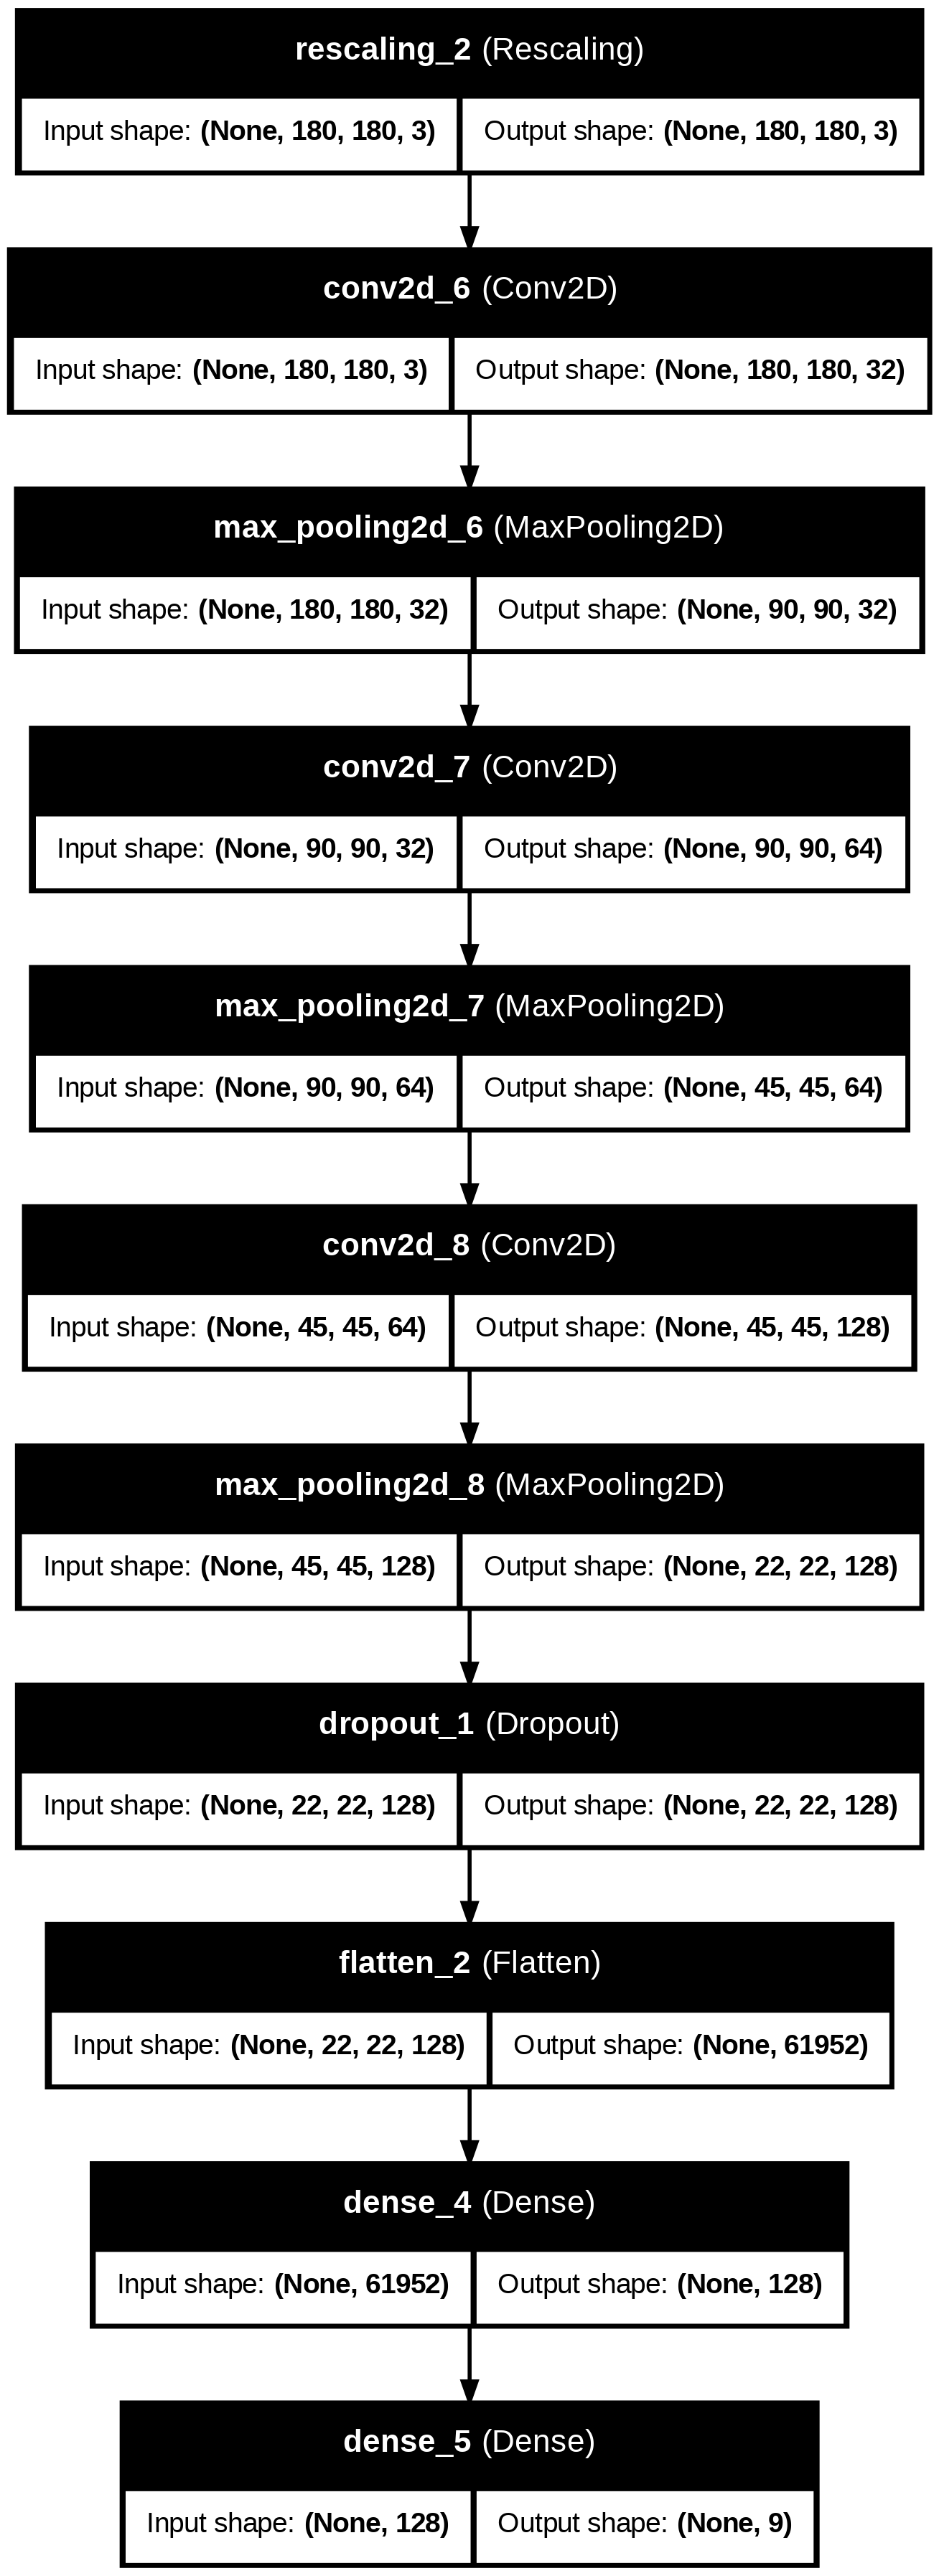

In [49]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Todo:** Visualize the model results

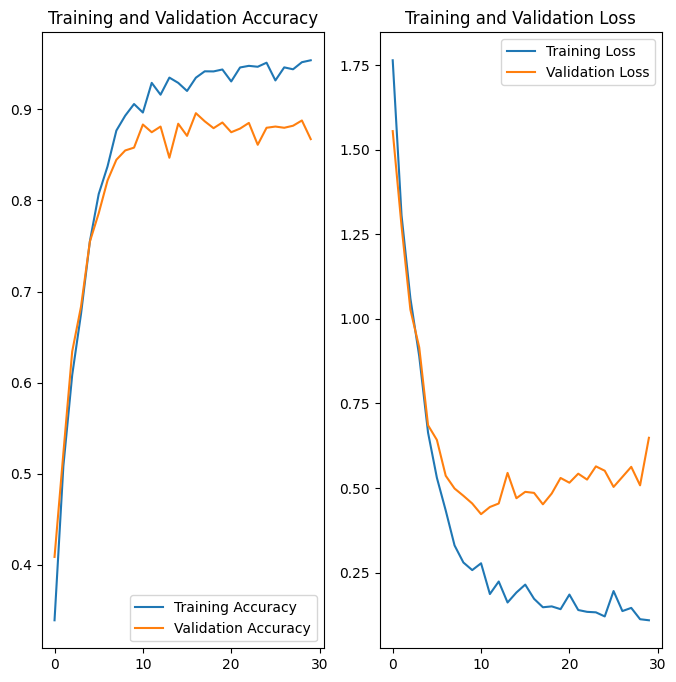

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Yes, We can clearly see it does helped.

Inference: From the above model we can clearly say that the above model has eradicated both the overfitting and underfitting problem. The rebalance using Augementor Module balanced each classes by adding augmented image by a fixed amount (here 500). There by giving equal importance to all the input classes hence this model is a right fit with, 93% and 83% of accuracies of train and validation set respectively.

Model Prediction

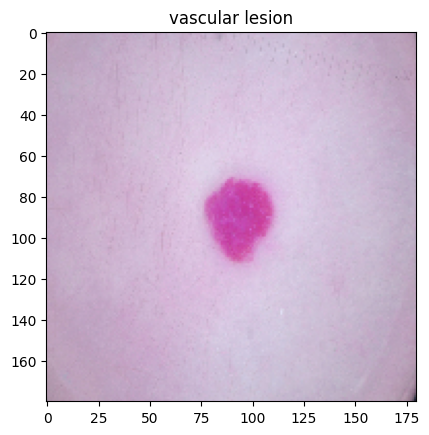

In [51]:
from tensorflow.keras.preprocessing.image import load_img

Test_image_path = os.path.join(data_dir_test, class_names[-1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.title(class_names[-1])
plt.grid(False)

In [52]:
img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[-1] +'\n'+ "Predictive Class "+pred_class )

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step
Actual Class vascular lesion
Predictive Class vascular lesion
